In [2]:
# This Python 3 environment.yml comes with many helpful analytics libraries installed
# This was ran on Google Colab but can also be ran locally or on HPC, will need to be configured accordingly
# This program only trains / creates the CNN, the output then is linked to the other Python files for webcam interface
# fer2013.csv is needed for this https://www.kaggle.com/datasets/msambare/fer2013

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import scipy
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Loading dataset
#df = pd.read_csv('/Users/admin/Desktop/200epoch/fer2013.csv')
#df.head()

df = pd.read_csv('/content/drive/MyDrive/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB


In [8]:
# Preprocessing dataset
# Assigning Names to Emotions in labels
num_classes = 7
width = 48
height = 48
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
classes=np.array(("Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"))
df.Usage.value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [9]:
k = np.array(list(map(int,df.iloc[0,1].split(" "))),dtype='uint8').reshape((48,48))

In [10]:
k.shape

(48, 48)

In [11]:
# Splitting data into training and testing sets
# Thse are empty lists
X_train = []
y_train = []
X_test = []
y_test = []

In [12]:
# Iterating over the dataset and splitting into train/test sets based on the 'Usage' column
"""
FOR: This for loop iterates over each row in the DataFrame df using the iterrows() method.
index contains the index of the current row, and row contains the data in that row.

k = row : For each row, the pixel values are extracted from the 'pixels' column
 and split into a list of strings using the space delimiter. This list is stored in variable k
"""
for index, row in df.iterrows():
    k = row['pixels'].split(" ")
    if row['Usage'] == 'Training':
        X_train.append(np.array(k))
        y_train.append(row['emotion'])
    elif row['Usage'] == 'PublicTest':
        X_test.append(np.array(k))
        y_test.append(row['emotion'])

In [13]:
X_train[0]

array(['70', '80', '82', ..., '106', '109', '82'], dtype='<U3')

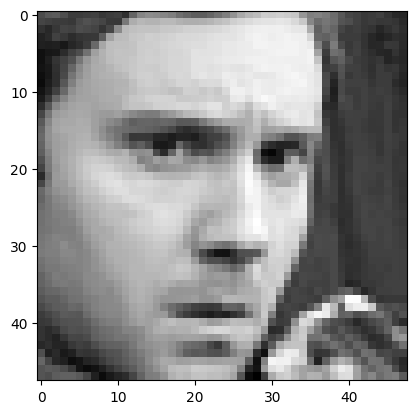

In [14]:
# This line displays the first image in the training set using Matplotlib's imshow() function.
# The pixel values are reshaped into a 48x48 array and displayed in grayscale (cmap='gray').
plt.imshow(np.array(X_train[0], dtype = 'uint8').reshape(48,48,1), cmap = 'gray')

In [15]:
# Reshaping the data for training and testing for CNN
X_train = np.array(X_train, dtype = 'uint8')
y_train = np.array(y_train, dtype = 'uint8')
X_test = np.array(X_test, dtype = 'uint8')
y_test = np.array(y_test, dtype = 'uint8')

In [16]:
#Re-shape to 4D Array
"""
The first dimension represents the number of samples,
the second and third dimensions represent the height and width of the images (48x48 pixels),
 and the fourth dimension represents the number of channels (1 for grayscale images).
"""
X_train = X_train.reshape(X_train.shape[0], 48, 48, 1)
X_test = X_test.reshape(X_test.shape[0], 48, 48, 1)

In [17]:
X_train.shape

(28709, 48, 48, 1)

Image Augmentation

In [18]:
import keras
from keras.utils import to_categorical
#from keras.utils.np_utils import to_categorical

In [19]:
# Performing one-hot encoding for target labels
y_train= to_categorical(y_train, num_classes=7)
y_test = to_categorical(y_test, num_classes=7)

In [20]:
"""### some image augumentation"""

'### some image augumentation'

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,         # Scale pixel values to the range [0, 1]
    rotation_range = 10,    # rotate images by up to 10 degrees
    horizontal_flip = True,
    width_shift_range=0.1,  # Shift images horizontally by up to 10% of the total width
    height_shift_range=0.1, # Shift images vertically by up to 10% of the total height
    fill_mode = 'nearest')  # Fill in any newly created pixels during augmentation using the nearest pixel value.

In [22]:
testgen = ImageDataGenerator(
    rescale=1./255      # rescaling of pixel values
    )
datagen.fit(X_train)
batch_size = 64     # number of samples per gradient update during training

In [23]:
# Generating augmented data flows
train_flow = datagen.flow(X_train, y_train, batch_size=batch_size)
test_flow = testgen.flow(X_test, y_test, batch_size=batch_size)

<ipython-input-24-ef32b9835339>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(330 + 1 + i)


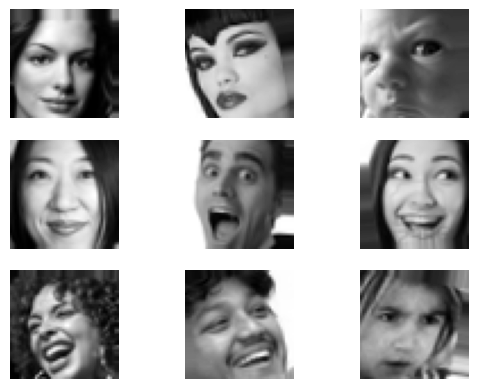

In [24]:
# Visualizing augmented images
"""
this code snippet allows to visualize a small subset of augmented images generated from the
training data, providing insight into how data augmentation affects the appearance of the images.
It's a helpful step in verifying the effectiveness and appropriateness of the
augmentation techniques applied to the training dataset.
"""
# The X_batch variable holds a batch of augmented images, and y_batch contains their corresponding labels.
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=9):
    for i in range(0, 9):
        plt.axis('off')
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(48, 48), cmap=plt.get_cmap('gray'))       # Reshpae image
    plt.axis('off')
    plt.show()
    break

In [25]:
"""#### Creating model for training"""

'#### Creating model for training'

In [26]:
from keras.layers import ZeroPadding2D,Convolution2D,MaxPooling2D,Flatten,Dense,Dropout
from keras.models import Sequential

In [27]:
from keras.utils import plot_model
#from keras.utils.vis_utils import plot_model

In [28]:
from keras.models import Model
from keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import concatenate
#from keras.optimizers import Adam, SGD
from tensorflow.keras.optimizers import Adam, SGD

In [29]:
from keras.regularizers import l1, l2
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

Defining the model architecture

In [30]:
def FER_Model(input_shape=(48,48,1)):
    # first input model
        # Define the input layer with the specified input shape
    visible = Input(shape=input_shape, name='input')
    num_classes = 7     # Number of output classes

    # First Convolutional Block
    # Convolutional layer with 64 filters, kernel size of 3x3, ReLU activation, and same padding to the visible layer
    conv1_1 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_1')(visible)
    # Batch normalization layer to normalize the activations of the previous layer
    conv1_1 = BatchNormalization()(conv1_1)
    # Second Convolutional layer with similar configuration as the first one
    conv1_2 = Conv2D(64, kernel_size=3, activation='relu', padding='same', name = 'conv1_2')(conv1_1)
    conv1_2 = BatchNormalization()(conv1_2)
    # MaxPooling layer to downsample the feature maps
    pool1_1 = MaxPooling2D(pool_size=(2,2), name = 'pool1_1')(conv1_2)
    # Dropout layer to prevent overfitting by randomly setting a fraction of input units to zero
    drop1_1 = Dropout(0.3, name = 'drop1_1')(pool1_1)

    # Second Convolutional Block
    # Similar structure as the first block with increased number of filters
    conv2_1 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_1')(drop1_1)
    conv2_1 = BatchNormalization()(conv2_1)
    conv2_2 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_2')(conv2_1)
    conv2_2 = BatchNormalization()(conv2_2)
    conv2_3 = Conv2D(128, kernel_size=3, activation='relu', padding='same', name = 'conv2_3')(conv2_2)
    conv2_2 = BatchNormalization()(conv2_3)
    pool2_1 = MaxPooling2D(pool_size=(2,2), name = 'pool2_1')(conv2_3)
    drop2_1 = Dropout(0.3, name = 'drop2_1')(pool2_1)

    # Third Convolutional Block
    # Similar structure with further increased number of filters
    conv3_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_1')(drop2_1)
    conv3_1 = BatchNormalization()(conv3_1)
    conv3_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_2')(conv3_1)
    conv3_2 = BatchNormalization()(conv3_2)
    conv3_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_3')(conv3_2)
    conv3_3 = BatchNormalization()(conv3_3)
    conv3_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv3_4')(conv3_3)
    conv3_4 = BatchNormalization()(conv3_4)
    pool3_1 = MaxPooling2D(pool_size=(2,2), name = 'pool3_1')(conv3_4)
    drop3_1 = Dropout(0.3, name = 'drop3_1')(pool3_1)

    # Fourth Convolutional Block
    # Similar structure with further increased number of filters
    conv4_1 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_1')(drop3_1)
    conv4_1 = BatchNormalization()(conv4_1)
    conv4_2 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_2')(conv4_1)
    conv4_2 = BatchNormalization()(conv4_2)
    conv4_3 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_3')(conv4_2)
    conv4_3 = BatchNormalization()(conv4_3)
    conv4_4 = Conv2D(256, kernel_size=3, activation='relu', padding='same', name = 'conv4_4')(conv4_3)
    conv4_4 = BatchNormalization()(conv4_4)
    pool4_1 = MaxPooling2D(pool_size=(2,2), name = 'pool4_1')(conv4_4)
    drop4_1 = Dropout(0.3, name = 'drop4_1')(pool4_1)


    # Fifth Convolutional Block
    # Similar structure with further increased number of filters
    conv5_1 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_1')(drop4_1)
    conv5_1 = BatchNormalization()(conv5_1)
    conv5_2 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_2')(conv5_1)
    conv5_2 = BatchNormalization()(conv5_2)
    conv5_3 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_3')(conv5_2)
    conv5_3 = BatchNormalization()(conv5_3)
    conv5_4 = Conv2D(512, kernel_size=3, activation='relu', padding='same', name = 'conv5_4')(conv5_3)
    conv5_3 = BatchNormalization()(conv5_3)
    pool5_1 = MaxPooling2D(pool_size=(2,2), name = 'pool5_1')(conv5_4)
    drop5_1 = Dropout(0.3, name = 'drop5_1')(pool5_1)

    #Flatten and output
    flatten = Flatten(name = 'flatten')(drop5_1)
    """
    a dense layer with softmax activation is added to produce the output of the model.
    The number of units in this layer is equal to the number of classes (7 in this case),
    and it will output the probability distribution over the classes.
    """
    ouput = Dense(num_classes, activation='softmax', name = 'output')(flatten)

    # create model
    model = Model(inputs =visible, outputs = ouput)
    # summary layers
    print(model.summary())

    return model

In [31]:
# Creating and compiling the model
model = FER_Model()
#opt = Adam(learning_rate=0.0001)
#model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 48, 48, 1)]       0         
                                                                 
 conv1_1 (Conv2D)            (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv1_2 (Conv2D)            (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 pool1_1 (MaxPooling2D)      (None, 24, 24, 64)        0     

In [32]:
from keras.callbacks import ModelCheckpoint

In [33]:
filepath = "weights_min_loss.keras"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [34]:
print('\n*-*-*-*-*-*-*-*-*-*-Just before epoch*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-\n')
# Training the model
num_epochs = 120
history = model.fit(train_flow,
                    steps_per_epoch=int(len(X_train) / batch_size),
                    epochs=num_epochs,
                    verbose=2,
                    callbacks=callbacks_list,
                    validation_data=test_flow,
                    validation_steps=int(len(X_test) / batch_size))


*-*-*-*-*-*-*-*-*-*-Just before epoch*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-*-

Epoch 1/120

Epoch 1: val_loss improved from inf to 1.94125, saving model to weights_min_loss.keras
448/448 - 59s - loss: 2.1438 - accuracy: 0.2272 - val_loss: 1.9412 - val_accuracy: 0.2489 - 59s/epoch - 131ms/step
Epoch 2/120

Epoch 2: val_loss improved from 1.94125 to 1.75482, saving model to weights_min_loss.keras
448/448 - 39s - loss: 1.7714 - accuracy: 0.2720 - val_loss: 1.7548 - val_accuracy: 0.2746 - 39s/epoch - 87ms/step
Epoch 3/120

Epoch 3: val_loss improved from 1.75482 to 1.68767, saving model to weights_min_loss.keras
448/448 - 41s - loss: 1.6755 - accuracy: 0.3337 - val_loss: 1.6877 - val_accuracy: 0.3599 - 41s/epoch - 92ms/step
Epoch 4/120

Epoch 4: val_loss did not improve from 1.68767
448/448 - 39s - loss: 1.4870 - accuracy: 0.4231 - val_loss: 1.7996 - val_accuracy: 0.3396 - 39s/epoch - 88ms/step
Epoch 5/120

Epoch 5: val_loss improved from 1.68767 to 1.34333, saving model to weights_min_loss.keras

In [35]:
"""### for testing"""

'### for testing'

In [36]:
%matplotlib inline
# Plotting training history
train_loss=history.history['loss']
val_loss=history.history['val_loss']
train_acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

In [37]:
epochs = range(len(train_acc))

<Figure size 640x480 with 0 Axes>

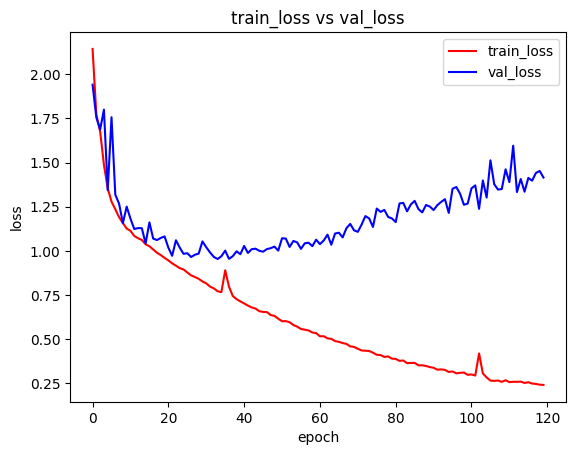

<Figure size 640x480 with 0 Axes>

In [38]:
plt.plot(epochs,train_loss,'r', label='train_loss')
plt.plot(epochs,val_loss,'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
# Save the figure
plt.savefig('loss_plot.png')
plt.figure()

<Figure size 640x480 with 0 Axes>

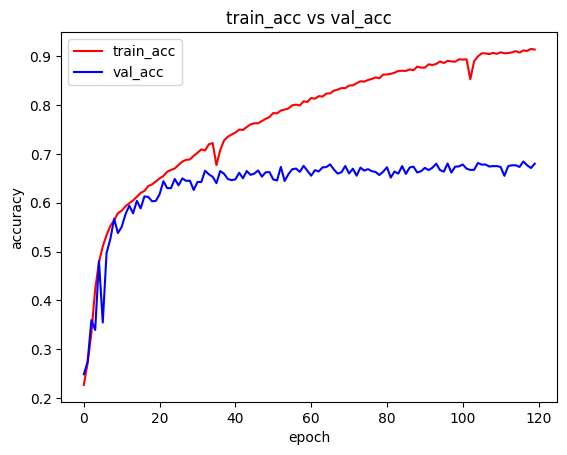

<Figure size 640x480 with 0 Axes>

In [39]:
plt.plot(epochs,train_acc,'r', label='train_acc')
plt.plot(epochs,val_acc,'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
# Save the figure
plt.savefig('accuracy_plot.png')
plt.figure()

In [40]:
# Evaluating the model on test data
#model.save('/Users/admin/Desktop/200epoch/Fer2013.keras')
model.save('/content/Fer2013.keras')

In [41]:
loss = model.evaluate(X_test/255., y_test)
print("Test Loss " + str(loss[0]))
print("Test Acc: " + str(loss[1]))

113/113 [==============================] - 3s 18ms/step - loss: 1.4140 - accuracy: 0.6801
Test Loss 1.4140448570251465
Test Acc: 0.6801337599754333


In [42]:
import itertools

In [43]:
def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    np.set_printoptions(precision=2)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')
    plt.show()


113/113 [==============================] - 2s 12ms/step


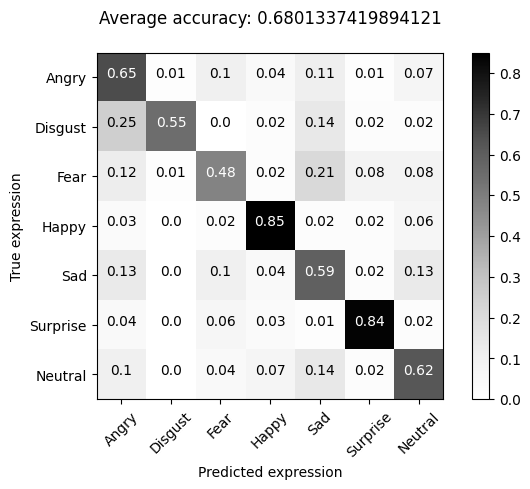

<Figure size 640x480 with 0 Axes>

In [44]:
# Plotting confusion matrix
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys, title='Average accuracy: ' +
                            str(np.sum(y_pred == t_te)/len(t_te)) + '\n')
plt.savefig('confusion_matrix.png', bbox_inches='tight', pad_inches=0.1)


113/113 [==============================] - 1s 13ms/step


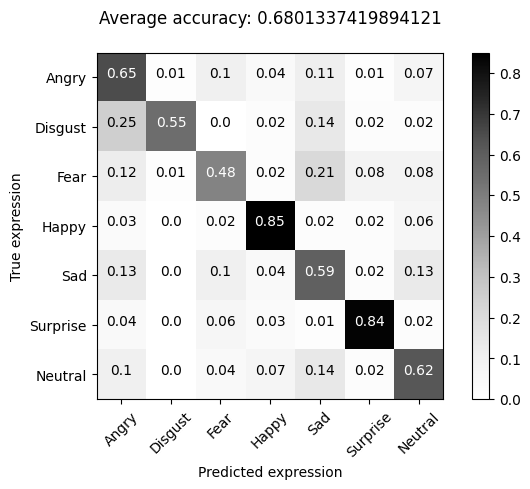

In [45]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_test, y_pred, classes,
                          normalize=False,
                          title='Unnormalized confusion matrix',
                          cmap=plt.cm.Blues):
    cm = confusion_matrix(y_test, y_pred)

    if normalize:
        cm = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], 2)

    np.set_printoptions(precision=2)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    thresh = cm.min() + (cm.max() - cm.min()) / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True expression')
    plt.xlabel('Predicted expression')

    # Save the plot
    plt.savefig('confusion_matrix.png', format='png')
    plt.show()

# Example usage:
# Plotting confusion matrix
y_pred_ = model.predict(X_test/255., verbose=1)
y_pred = np.argmax(y_pred_, axis=1)
t_te = np.argmax(y_test, axis=1)
fig = plot_confusion_matrix(y_test=t_te, y_pred=y_pred,
                      classes=classes,
                      normalize=True,
                      cmap=plt.cm.Greys, title='Average accuracy: ' + str(np.sum(y_pred == t_te)/len(t_te)) + '\n')


In [46]:
# Saving the model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
#model.save_weights("/Users/admin/Desktop/200epoch/model.h5")
model.save_weights("/content/model.h5")

print("Saved model to disk")

Saved model to disk
